In [122]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker, scoped_session
from database.models.Block import Block
from database.models.Tx import Tx
from database.models.Receipt import Receipt
from database.models.Ticker_ETHUSDT_15m import Ticker_ETHUSDT_15m
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import ta

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
from typing import Any, Dict, List, Optional


import eli5


pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_columns", None)


Create session to DB

In [3]:
engine = create_engine("sqlite:///db.sqlite")
session_factory = sessionmaker(bind=engine)
Session = scoped_session(session_factory)
session = Session()


Get BLOCKS data from DB

In [128]:

blocks = [row.__dict__ for row in session.query(Block).all()]
blocks_df = pd.DataFrame(blocks)
del blocks_df["_sa_instance_state"]

blocks_df.set_index("timestamp", inplace=True)
first_block_timestamp = int(blocks_df.index.min())
last_block_timestamp = int(blocks_df.index.max())
first_block_num = int(blocks_df["blockNumber"].min())
last_block_num = int(blocks_df["blockNumber"].max())
blocks_df.head()


,miner,stateRoot,difficulty,mixHash,baseFeePerGas,nonce,totalDifficulty,extraData,blockNumber,transactions,gasLimit,parentHash,transactionsRoot,gasUsed,receiptsRoot,uncles,blockHash,sha3Uncles,logsBloom,size
timestamp,,,,,,,,,,,,,,,,,,,,
1663224155,0x829BD824B016326A401d083B33D092293333A830,0xb8d426f8c8b6ae1c34f6bebf904971be1611c29e8889...,11043900012338719,0x3cb45555281bd222aa7ec335efab51e99313814e03cc...,37949635702,0xac2c3800025a764f,58749981610968571282265,0xe4b883e5bda9e7a59ee4bb99e9b1bc4b2e22,15537391,[HexBytes('0x7d354eee5c08004aa1b8a3a05e1cf9cd3...,30000000,0xd5b9efdd3659f5b635e0505d787d6b6cc3af4c660def...,0xd976f002afbac9fdf1b028336719b602b9f4660ca103...,16969164,0x6b4d994610806d8a5ed107996abc477688d4d0748763...,[],0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x53a240c0610070015299420086041090205a11062100...,47274
1663224156,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0xfee48a40a2765ab31fcd06ab6956341d13dc2c4b9762...,11049842297455506,0x2df332ffb74ecd15c9873d3f6153b878e1c514495dfb...,38572377838,0x232b0043952c93d9,58749992660810868737771,0x617369612d65617374322d31763932,15537392,[HexBytes('0x720322369bd103b7c064db34bfdc43836...,30000000,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,0x82864b3a65d1ac1917c426d48915dca0fc966fbf3f30...,29990952,0x13c10513b52358022f800e2f9f1c50328798427b1b4a...,[],0x2b3ea3cd4befcab070812443affb08bf17a91ce382c7...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0xffffffffffffffffffffffffffffffffffffffffffff...,16568
1663224162,0x829BD824B016326A401d083B33D092293333A830,0x4919dafa6ac8becfbbd0c2808f6c9511a057c21e4283...,11055787484078698,0x4cbec03dddd4b939730a7fe6048729604d4266e82426...,43391016710,0x62a3ee77461d4fc9,58750003716598352816469,0xe4b883e5bda9e7a59ee4bb99e9b1bc460021,15537393,[HexBytes('0xec9db5bfbcd30ad2e3070b626ed4f78ab...,30000000,0x2b3ea3cd4befcab070812443affb08bf17a91ce382c7...,0xdd5eec02b019ff76e359b09bfa19395a2a0e97bc01e7...,29991429,0xbaa842cfd552321a9c2450576126311e071680a12580...,[],0x55b11b918355b1ef9c5db810302ebad0bf2544255b53...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x00000400000000000000000000000000000000000000...,1636
1663224179,0xeEE27662c2B8EBa3CD936A23F039F3189633e4C8,0x40c07091e16263270f3579385090fea02dd5f061ba67...,0,0xa86c2e601b6c44eb4848f7d23d9df3113fbcac42041c...,48811794595,0x0000000000000000,58750003716598352816469,0x,15537394,[HexBytes('0x5ad934ee3bf2f8938d8518a3b978e81f1...,30000000,0x55b11b918355b1ef9c5db810302ebad0bf2544255b53...,0x1ea1746468686159ce730c1cc49a886721244e5d1fa9...,29983006,0x928073fb98ce316265ea35d95ab7e2e1206cecd85242...,[],0x56a9bb0302da44b8c0b3df540781424684c3af04d0b7...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0xffffffffffffffffffffffffffffffffffffffffffff...,18559
1663224191,0x0b3b161b8ABEB6b04CB95c3e6047f80c120A0292,0x2ca38a39c5517f658d107c19550334a9820a7393d148...,0,0xfd7be062e87b2193dff12ca89e90bbf61684e6676df4...,54906356355,0x0000000000000000,58750003716598352816469,0x,15537395,[HexBytes('0x7d5304e1c5c38e4a33d1105ef21804762...,30000000,0x56a9bb0302da44b8c0b3df540781424684c3af04d0b7...,0x5c56184fbce74e9c98d2a51aa2110963396047d84e8c...,29982083,0x1707e457973ce280debe93f5d478663d97ad192beea1...,[],0xe37e1a183a3d1c7234d090bfb7196081635919c26f2e...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0xffffffffffffffffffffffffffffffffffffffffffff...,36978


In [129]:
txs = [row.__dict__ for row in session.query(Tx).filter((Tx.blockNumber >= first_block_num) & (Tx.blockNumber <= last_block_num))]
txs_df = pd.DataFrame(txs)
del txs_df["_sa_instance_state"]
# txs_df.set_index("blockNumber", inplace=True)

txs_df.head()


,blockNumber,r,maxPriorityFeePerGas,chainId,s,addressFrom,addressTo,gas,transactionIndex,gasPrice,type,tx_hash,v,blockHash,input,value,accessList,nonce,maxFeePerGas
0,15537391,0xc56e17a90dc6805a7595e68f648860f7907ee6f8b032...,1625309256.00,0x1,0x756f5c5de563109bcdaa2233505b89c79033333d8482...,0xF8e9169097B1D8B375497EeB1ac27Ec07ed147ba,0x7Bc25283a29A3888CAb4555Ea86fF1a8C18Cc90a,180000,71,39574944958,0x2,0x004313ffe602d31dcb4ec2576acddbc8aa169da05d90...,0,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,0x1249c58b,0.00,[],84,51832439481.00
1,15537391,0x7217b3de915f59d0ffc7b54068aee142a285e9526d81...,1625309256.00,0x1,0x77d087df107199288bb1032609fc6b4d167b19606168...,0xEE2AA901CFd291471e7C2c15de2ED904468200C6,0x5696aa328B0cc25199D4D3Bb486AFe1026C88eb3,104103,78,39574944958,0x2,0x0070fe7ea09874cbc45163ad8f55f8612475fa52bf85...,1,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,0xbce6d672,25000000000000000.00,[],124,50846581695.00
2,15537391,0x1e12aecf6742fcf7963dc1ee37f83b0fd0fd32007a74...,1625309256.00,0x1,0x6fb366467280f47be60f4c9ba7580b4fe20b68978e94...,0x25E6D7b6A6Dbff4e9775F0988c4125ec1A65681d,0x7Bc25283a29A3888CAb4555Ea86fF1a8C18Cc90a,180000,82,39574944958,0x2,0x080a4490e2f3806443cc9615458f8c656ae7754544c6...,0,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,0x1249c58b,0.00,[],320,51832439481.00
3,15537391,0x12d7491885d4e42db1a6aeece3cbfb3d370ffaa1bc80...,1123000000.00,0x1,0x60b0960b60e1f01eadf556dc7236cbad70b66b39bbcd...,0x69DC7BD9D94f5B836A9Cbadc503b4142CE457e36,0x7Bc25283a29A3888CAb4555Ea86fF1a8C18Cc90a,239450,102,39072635702,0x2,0x0e0dc69b0da0a3458a6d9ae9194ee6da9bc3641399ab...,1,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,0x1249c58b,0.00,[],522,50000000000.00
4,15537391,0xe2a84c33fb0f0ff5750d1d5af53d6e245f3091146689...,3000000000.00,0x1,0x4137184202603356016f143b73dc1f4df5732aba6d2f...,0x6EEf09B526d883F98762a7005FABD2c800DfCA44,0x7Bc25283a29A3888CAb4555Ea86fF1a8C18Cc90a,215160,19,40949635702,0x2,0x0f14eeca5f1394816eb4302293b834fc531c41d55c25...,0,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,0x1249c58b,0.00,[],17052,100000000000.00


In [130]:
receipts = [row.__dict__ for row in session.query(Receipt).filter((Receipt.blockNumber >= first_block_num) & (Receipt.blockNumber <= last_block_num))]
receipts_df = pd.DataFrame(receipts)
del receipts_df["_sa_instance_state"]

receipts_df.head()

,effectiveGasPrice,blockNumber,contractAddress,fromAddress,logs,status,balanceFrom,tx_hash,type,cumulativeGasUsed,blockHash,gasUsed,logsBloom,toAddress,balanceTo,transactionIndex,root
0,69420314159,15537391,None,0xB578405Df1F9D4dFdD46a0BD152D518d4c5Fe0aC,[],0,295018501075532800.00,0x7d354eee5c08004aa1b8a3a05e1cf9cd348ee88be456...,0x2,21341,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,21341,0x00000000000000000000000000000000000000000000...,0xc86E1A7a4AA5A9B17f6997a59B311835fc95e975,0.00,0,None
1,69000000000,15537391,None,0x122B96a341Ab8da83EB86F4DceFAA4b1D43125E9,[AttributeDict({'address': '0x7Bc25283a29A3888...,1,150256782151638784.00,0x105acb5c3118b319e0bd2a50e1e1f5c71f2761337efc...,0x2,197841,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,176500,0x10000000000000000080000000000000000000000000...,0x7Bc25283a29A3888CAb4555Ea86fF1a8C18Cc90a,0.00,1,None
2,57949635702,15537391,None,0xdf0e3867920D812b74D05B19Da043679F1082512,[AttributeDict({'address': '0x7Bc25283a29A3888...,1,19773723016364552.00,0x2c6d2799f6a4d958264297a10a0782c1eec6cd6f22dc...,0x2,374341,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,176500,0x10000000000000010000020000000000000000000000...,0x7Bc25283a29A3888CAb4555Ea86fF1a8C18Cc90a,0.00,2,None
3,57949635702,15537391,None,0x23bc95F84BD43C1FCc2bc285fDa4Cb12f9AEE2df,[],1,124610201197050064.00,0xebbbf696a61de0d588aad04b55208e94edd71689f83f...,0x2,399293,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,24952,0x00000000000000000000000000000000000000000000...,0x23bc95F84BD43C1FCc2bc285fDa4Cb12f9AEE2df,124610201197050064.00,3,None
4,44493182647,15537391,None,0xeeFd3779a860234ba029c618bab331f4f19AFCE3,[],1,72554039653915200.00,0xf8bc06020fc243959c8ef4be0b303370567af38be17a...,0x0,429996,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,30703,0x00000000000000000000000000000000000000000000...,0xdb7A53E6AE058E1Dcf4502341E2ADFA522E2B29F,0.00,4,None


In [131]:
ticker = [row.__dict__ for row in session.query(Ticker_ETHUSDT_15m).filter((Ticker_ETHUSDT_15m.open_time >= first_block_timestamp*1000) & (Ticker_ETHUSDT_15m.close_time <= last_block_timestamp*1000))]
ticker_df = pd.DataFrame(ticker)
del ticker_df["_sa_instance_state"]
ticker_df.head()

,low,open,volume,quote_asset_volume,taker_buy_base_asset_volume,close,high,open_time,close_time,number_of_trades,taker_buy_quote_asset_volume
0,1580.10,1596.90,70719.24,113626302.03,35577.09,1599.85,1634.90,1663224300000,1663225199999,84035,57187354.58
1,1595.50,1599.86,36116.40,58098122.57,17091.59,1619.31,1619.90,1663225200000,1663226099999,45892,27505391.65
2,1617.51,1619.32,44313.70,72625581.84,24076.44,1635.98,1655.00,1663226100000,1663226999999,51938,39454418.41
3,1622.91,1635.98,25041.88,40859483.37,11227.45,1630.81,1641.00,1663227000000,1663227899999,31913,18323009.69
4,1626.52,1630.82,16930.27,27642820.80,7388.72,1636.65,1637.13,1663227900000,1663228799999,20985,12064050.39


In [132]:
blocks_size_sums = []
blocks_size_means = []
blocks_base_fees_per_gas = []
blocks_gas_used_totals = []
blocks_gas_used_means = []
txs_mean_per_block = []
txs_count_per_candle = []
txs_max_fee_per_gas_mean = []
txs_max_priority_per_gas_mean = []
txs_gas_price_mean = []
txs_value_sum = []
txs_value_mean = []
rcpts_cumul_gas_used_mean = []
rcpts_effec_gas_price_mean = []
rcpts_contract_tx_count = []
rcpts_contract_tx_mean_per_block = []

for index, tick in ticker_df.iterrows():
    
    block_timestamp = blocks_df.index*1000
    blocks = blocks_df[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["blockNumber"].tolist()

    blocks_size_sums.append(blocks_df[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["size"].sum())
    blocks_size_means.append(blocks_df[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["size"].mean())
    blocks_base_fees_per_gas.append(blocks_df[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["baseFeePerGas"].mean())
    blocks_gas_used_totals.append(blocks_df[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["gasUsed"].sum())
    blocks_gas_used_means.append(blocks_df[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["gasUsed"].mean())
    txs_mean_per_block.append(txs_df.loc[txs_df["blockNumber"].isin(blocks), "blockNumber"].count()/len(blocks))
    txs_count_per_candle.append(txs_df.loc[txs_df["blockNumber"].isin(blocks), "blockNumber"].count())
    txs_max_fee_per_gas_mean.append(txs_df.loc[txs_df["blockNumber"].isin(blocks), "maxFeePerGas"].mean())
    txs_max_priority_per_gas_mean.append(txs_df.loc[txs_df["blockNumber"].isin(blocks), "maxPriorityFeePerGas"].mean())
    txs_gas_price_mean.append(txs_df.loc[txs_df["blockNumber"].isin(blocks), "gasPrice"].mean())
    txs_value_sum.append(txs_df.loc[txs_df["blockNumber"].isin(blocks), "value"].sum())
    txs_value_mean.append(txs_df.loc[txs_df["blockNumber"].isin(blocks), "value"].mean())
    rcpts_cumul_gas_used_mean.append(receipts_df.loc[receipts_df["blockNumber"].isin(blocks), "cumulativeGasUsed"].mean())
    rcpts_effec_gas_price_mean.append(receipts_df.loc[receipts_df["blockNumber"].isin(blocks), "effectiveGasPrice"].mean())
    rcpts_contract_tx_count.append(receipts_df.loc[receipts_df["blockNumber"].isin(blocks), "contractAddress"].count())
    rcpts_contract_tx_mean_per_block.append(receipts_df.loc[receipts_df["blockNumber"].isin(blocks), "contractAddress"].count()/len(blocks))



ticker_df["blocks_size_sum"] = blocks_size_sums
ticker_df["blocks_size_mean"] = blocks_size_means
ticker_df["blocks_base_fee_per_gas"] = blocks_base_fees_per_gas
ticker_df["txs_mean_per_block"] = txs_mean_per_block
ticker_df["txs_count_per_candle"] = txs_count_per_candle
ticker_df["txs_max_fee_per_gas_mean"] = txs_max_fee_per_gas_mean
ticker_df["txs_max_priority_per_gas_mean"] = txs_max_priority_per_gas_mean
ticker_df["txs_gas_price_mean"] = txs_gas_price_mean
ticker_df["txs_value_sum"] = txs_value_sum
ticker_df["txs_value_mean"] = txs_value_mean
ticker_df["rcpts_cumul_gas_used_mean"] = rcpts_cumul_gas_used_mean
ticker_df["rcpts_effec_gas_price_mean"] = rcpts_effec_gas_price_mean
ticker_df["rcpts_contract_tx_count"] = rcpts_contract_tx_count
ticker_df["rcpts_contract_tx_mean_per_block"] = rcpts_contract_tx_mean_per_block

ticker_df = ta.add_volume_ta(ticker_df, "high", "low", "close", "volume", fillna=True)
ticker_df = ta.add_others_ta(ticker_df, "close", fillna=True)
ticker_df = ta.add_volatility_ta(ticker_df, "high", "low", "close", fillna=True)
ticker_df.drop(["volatility_bbhi", "volatility_kchi"], axis=1, inplace=True)



ticker_df.sort_values(by="close_time", ascending=False, inplace=True)
ticker_df["next_candle_close"] = ticker_df.close.shift(periods=1)

ticker_df.drop(ticker_df.head(1).index,inplace=True)


ticker_df
 



,low,open,volume,quote_asset_volume,taker_buy_base_asset_volume,close,high,open_time,close_time,number_of_trades,taker_buy_quote_asset_volume,blocks_size_sum,blocks_size_mean,blocks_base_fee_per_gas,txs_mean_per_block,txs_count_per_candle,txs_max_fee_per_gas_mean,txs_max_priority_per_gas_mean,txs_gas_price_mean,txs_value_sum,txs_value_mean,rcpts_cumul_gas_used_mean,rcpts_effec_gas_price_mean,rcpts_contract_tx_count,rcpts_contract_tx_mean_per_block,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,others_dr,others_dlr,others_cr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,next_candle_close
41,1507.58,1509.51,12664.41,19162710.82,5802.40,1515.50,1517.53,1663261200000,1663262099999,19387,8779661.54,5909520,78793.60,21444278548.68,195.29,14647,61873403745.79,5962674267.72,26421966991.83,25629928268763083309056.00,1749841487592208896.00,9580393.96,26421966991.83,8,0.11,-52439.17,44533.56,-0.18,-115364.24,511861.65,-480939.71,76.01,1508.61,26.62,988.89,0.40,0.40,-5.27,1536.49,1624.53,1448.45,11.46,0.38,0.00,1495.36,1513.16,1477.56,2.38,1.07,0.00,1458.00,1600.00,1529.00,9.24,0.40,16.73,5.21,1512.99
40,1501.99,1504.71,8074.96,12163219.58,4318.54,1509.51,1510.09,1663260300000,1663261199999,14445,6506510.84,6794903,91823.01,17879387841.96,203.51,15060,52455221348.02,4284003164.41,22248842919.75,32123379241050854916096.00,2133026510029937152.00,9696328.27,22248842919.75,15,0.20,-59935.99,31869.15,-0.19,-147234.91,370645.62,-572242.16,57.70,1511.03,22.58,988.89,0.32,0.32,-5.65,1540.35,1631.10,1449.60,11.78,0.33,0.00,1497.21,1520.66,1473.76,3.13,0.76,0.00,1458.00,1600.00,1529.00,9.22,0.36,17.48,5.08,1515.50
39,1497.17,1499.83,9838.57,14784985.46,5212.91,1504.71,1507.52,1663259400000,1663260299999,15393,7834739.46,6575444,91325.61,16656124902.33,196.72,14164,52986349071.26,4621382781.33,20675753984.75,51491325247598477967360.00,3635366086387918336.00,9555563.66,20675753984.75,13,0.18,-66854.54,23794.18,-0.20,-178234.03,914698.37,-654915.66,170.20,1513.43,19.83,985.75,0.32,0.32,-5.95,1544.45,1636.66,1452.24,11.94,0.28,0.00,1503.76,1529.07,1478.45,3.37,0.52,0.00,1458.00,1600.00,1529.00,9.19,0.33,18.53,4.91,1509.51
38,1484.60,1484.61,13468.18,20139084.32,7106.45,1499.84,1502.70,1663258500000,1663259399999,17134,10629886.88,6258542,84574.89,16820671821.45,190.38,14088,57803795887.86,7666434948.39,25199143314.62,82567604490232146165760.00,5860846428892116992.00,9813384.16,25199143314.62,10,0.14,-71350.82,13955.61,-0.24,-215925.34,702863.97,-730911.54,47.94,1515.41,16.83,982.56,1.03,1.02,-6.25,1548.64,1640.84,1456.43,11.91,0.24,0.00,1512.02,1537.23,1486.81,3.33,0.26,0.00,1458.00,1600.00,1529.00,9.17,0.29,19.43,4.71,1504.71
37,1483.46,1492.95,16167.62,24059090.79,8568.24,1484.60,1493.38,1663257600000,1663258499999,22244,12752133.54,5503929,75396.29,18395047817.33,203.73,14872,62112164827.00,8985648155.82,28080854106.90,55195249677467813675008.00,3711353528608648192.00,9935168.19,28080854106.90,14,0.19,-80562.76,487.43,-0.24,-286122.08,-141428.36,-786218.94,-76.79,1518.10,12.75,972.57,-0.56,-0.56,-7.20,1553.28,1644.53,1462.02,11.75,0.12,0.00,1520.88,1545.28,1496.48,3.21,-0.24,1.00,1458.00,1600.00,1529.00,9.14,0.19,19.58,4.47,1499.84
36,1486.00,1491.37,12930.25,19268163.22,6009.10,1492.94,1495.45,1663256700000,1663257599999,17782,8954109.59,5803062,77374.16,20935063481.92,175.11,13133,70330077439.07,7409169270.44,27342588916.60,182361870610373197955072.00,13885774050892652544.00,9744196.22,27342588916.60,13,0.17,-68111.08,16655.05,-0.20,-311336.11,-290145.14,-754597.53,54.71,1523.24,17.77,972.57,0.10,0.10,-6.68,1558.04,1644.27,1471.82,11.07,0.12,0.00,1530.14,1555.35,1504.93,3.29,-0.24,1.00,1458.00,1600.00,1529.00,9.11,0.25,20.66,4.11,1484.60
35,1487.21

In [133]:
ticker_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 41 to 0
Data columns (total 58 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   low                               42 non-null     float64
 1   open                              42 non-null     float64
 2   volume                            42 non-null     float64
 3   quote_asset_volume                42 non-null     float64
 4   taker_buy_base_asset_volume       42 non-null     float64
 5   close                             42 non-null     float64
 6   high                              42 non-null     float64
 7   open_time                         42 non-null     int64  
 8   close_time                        42 non-null     int64  
 9   number_of_trades                  42 non-null     int64  
 10  taker_buy_quote_asset_volume      42 non-null     float64
 11  blocks_size_sum                   42 non-null     int64  
 12  blocks_siz

In [134]:
ticker_df.columns

Index(['low', 'open', 'volume', 'quote_asset_volume',
       'taker_buy_base_asset_volume', 'close', 'high', 'open_time',
       'close_time', 'number_of_trades', 'taker_buy_quote_asset_volume',
       'blocks_size_sum', 'blocks_size_mean', 'blocks_base_fee_per_gas',
       'txs_mean_per_block', 'txs_count_per_candle',
       'txs_max_fee_per_gas_mean', 'txs_max_priority_per_gas_mean',
       'txs_gas_price_mean', 'txs_value_sum', 'txs_value_mean',
       'rcpts_cumul_gas_used_mean', 'rcpts_effec_gas_price_mean',
       'rcpts_contract_tx_count', 'rcpts_contract_tx_mean_per_block',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'others_dr', 'others_dlr', 'others_cr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volat

In [135]:
cont_features = ["low", "open", "volume", "quote_asset_volume",
       "taker_buy_base_asset_volume", "close", "high", "number_of_trades", "taker_buy_quote_asset_volume",
       "blocks_size_sum", "blocks_size_mean", "blocks_base_fee_per_gas",
       "txs_mean_per_block", "txs_count_per_candle",
       "txs_max_fee_per_gas_mean", "txs_max_priority_per_gas_mean",
       "txs_gas_price_mean", "txs_value_sum", "txs_value_mean",
       "rcpts_cumul_gas_used_mean", "rcpts_effec_gas_price_mean",
       "rcpts_contract_tx_count", "rcpts_contract_tx_mean_per_block",
       "volume_adi", "volume_obv", "volume_cmf", "volume_fi", "volume_em",
       "volume_sma_em", "volume_vpt", "volume_vwap", "volume_mfi",
       "volume_nvi", "others_dr", "others_dlr", "others_cr", "volatility_bbm",
       "volatility_bbh", "volatility_bbl", "volatility_bbw", "volatility_bbp",
       "volatility_bbli", "volatility_kcc", "volatility_kch", "volatility_kcl",
       "volatility_kcw", "volatility_kcp", "volatility_kcli", "volatility_dcl",
       "volatility_dch", "volatility_dcm", "volatility_dcw", "volatility_dcp",
       "volatility_atr", "volatility_ui"]

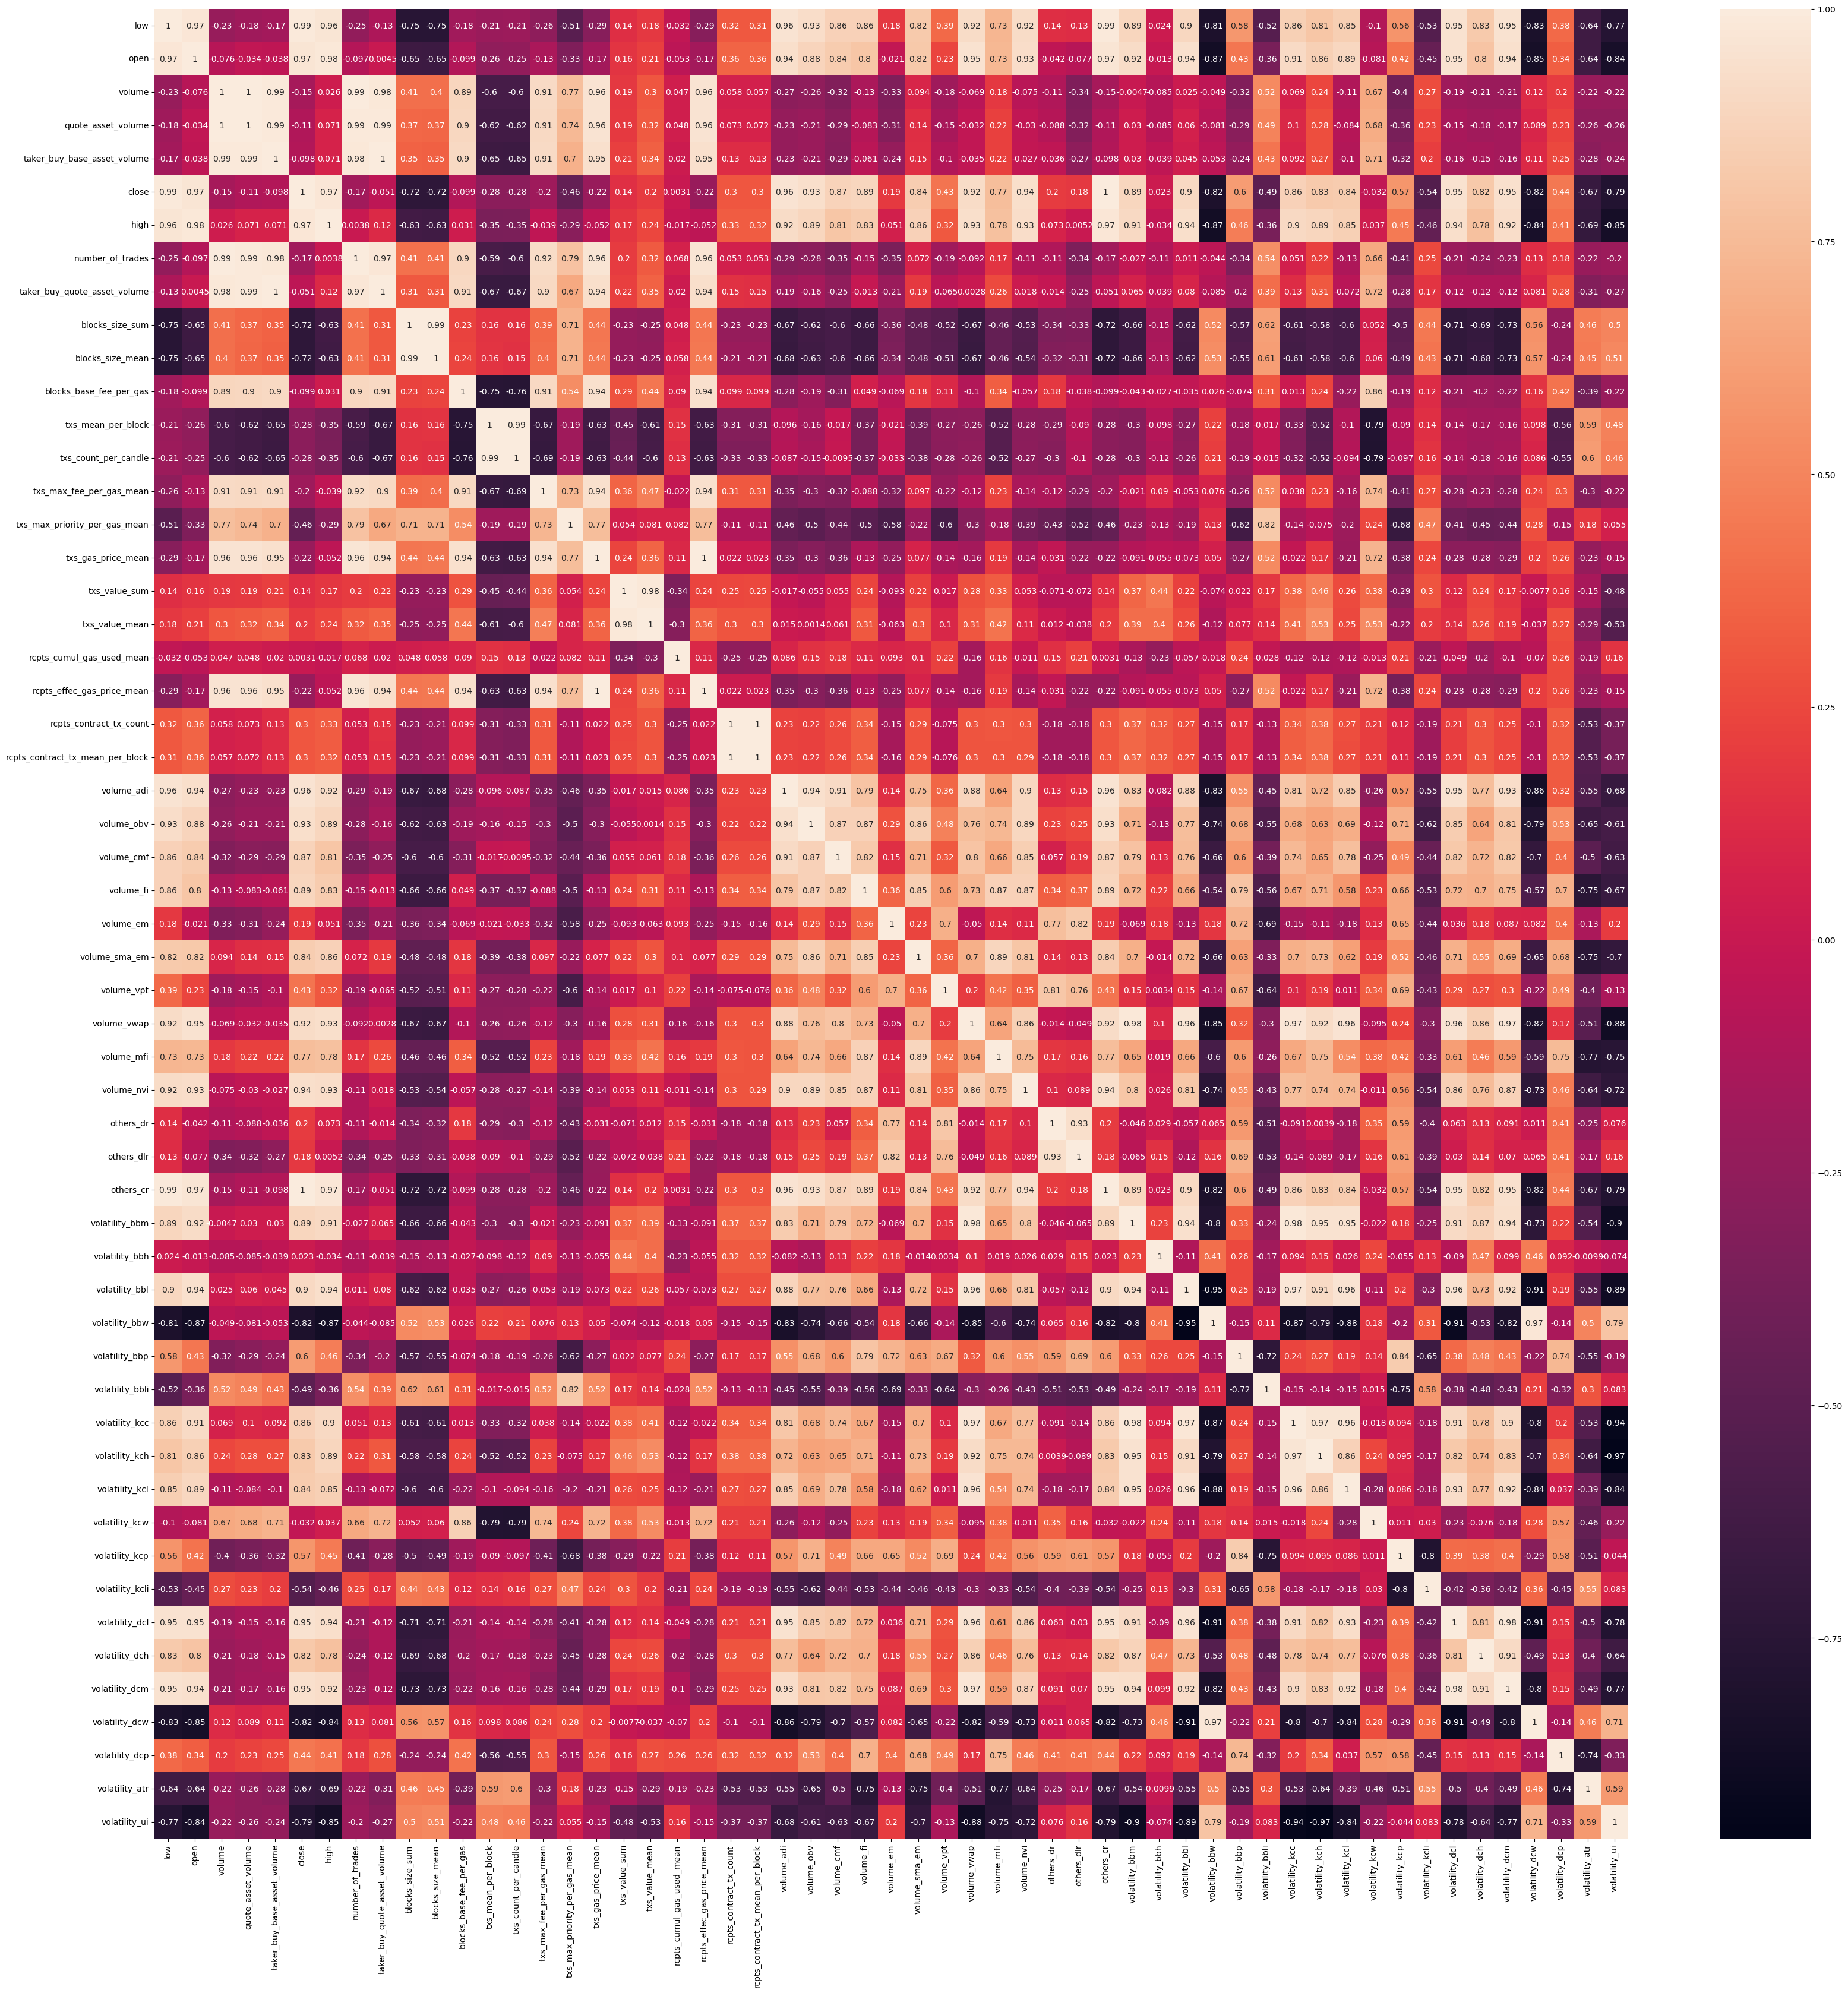

In [136]:
plt.figure(figsize=(40, 40))
corr = ticker_df[cont_features].corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [137]:
cont_pipeline = Pipeline([
    ("scaler", StandardScaler()),
])

In [138]:
pipeline = Pipeline([
    ("ColumnTransformer", ColumnTransformer([
        ("cont_transformer", cont_pipeline, cont_features),
    ])),
    ("model", LinearRegression())
])

In [139]:
train_df, test_df = train_test_split(ticker_df)
print("Train size: ", train_df.size)
print("Test size: ", test_df.size)

Train size:  1798
Test size:  638


In [140]:
pipeline.fit(train_df, train_df["next_candle_close"].values)

Pipeline(steps=[('ColumnTransformer',
                 ColumnTransformer(transformers=[('cont_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['low', 'open', 'volume',
                                                   'quote_asset_volume',
                                                   'taker_buy_base_asset_volume',
                                                   'close', 'high',
                                                   'number_of_trades',
                                                   'taker_buy_quote_asset_volume',
                                                   'blocks_size_sum',
                                                   'blocks_size_mean',
                                                   'blocks_base_fee_per_gas',
                                                   'txs_mean_per...
                                                   'txs_max_fee_per_gas_mean',
                                                   'txs_max_priority_per_gas_mean',
                                                   'txs_gas_price_mean',
                                                   'txs_value_sum',
                                                   'txs_value_mean',
                                                   'rcpts_cumul_gas_used_mean',
                                                   'rcpts_effec_gas_price_mean',
                                                   'rcpts_contract_tx_count',
                                                   'rcpts_contract_tx_mean_per_block',
                                                   'volume_adi', 'volume_obv',
                                                   'volume_cmf', 'volume_fi',
                                                   'volume_em', 'volume_sma_em',
                                                   'volume_vpt', ...])])),
                ('model', LinearRegression())])

In [143]:
print("LinearReg")
predictions = pipeline.predict(test_df)
print("MAE: ", mean_absolute_error(test_df["next_candle_close"], predictions))
print("MSE: ", mean_squared_error(test_df["next_candle_close"], predictions))

LinearReg
MAE:  30.544547331112014
MSE:  3093.8805739369363


In [144]:
test_df.head(1)

,low,open,volume,quote_asset_volume,taker_buy_base_asset_volume,close,high,open_time,close_time,number_of_trades,taker_buy_quote_asset_volume,blocks_size_sum,blocks_size_mean,blocks_base_fee_per_gas,txs_mean_per_block,txs_count_per_candle,txs_max_fee_per_gas_mean,txs_max_priority_per_gas_mean,txs_gas_price_mean,txs_value_sum,txs_value_mean,rcpts_cumul_gas_used_mean,rcpts_effec_gas_price_mean,rcpts_contract_tx_count,rcpts_contract_tx_mean_per_block,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,others_dr,others_dlr,others_cr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,next_candle_close
0,1580.10,1596.90,70719.24,113626302.03,35577.09,1599.85,1634.90,1663224300000,1663225199999,84035,57187354.58,5013042,67743.81,71178182467.20,110.65,8188,133267508917.13,13359332194.47,83174912105.29,101082683801613153337344.00,12345222740793008128.00,9252197.62,83174912105.29,14,0.19,-19744.61,70719.24,-0.28,0.00,0.00,0.00,1354.05,1604.95,50.00,1000.00,1.95,0.00,0.00,1599.85,1599.85,1599.85,0.00,0.00,0.00,1604.95,1659.75,1550.15,6.83,0.45,0.00,1580.10,1634.90,1607.50,3.43,0.36,0.00,0.00,1619.31


In [145]:
pipeline.predict(test_df.head(1))

array([1447.10225903])

In [146]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [147]:
feature_names = get_feature_names(pipeline.named_steps["ColumnTransformer"])

/var/folders/jt/jttvrgbx7pxgyn407jvmp9000000gn/T/ipykernel_43980/2197783060.py:30: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [148]:
eli5.explain_weights(pipeline.named_steps["model"], top=50, feature_names=feature_names)

Weight?,Feature
+1562.797,<BIAS>
+46.878,cont_transformer__volume_cmf
+44.069,cont_transformer__high
+28.510,cont_transformer__number_of_trades
+25.352,cont_transformer__volatility_dcl
+23.525,cont_transformer__volatility_dcm
+19.269,cont_transformer__txs_count_per_candle
+19.180,cont_transformer__volume_fi
+18.879,cont_transformer__txs_value_sum
+17.107,cont_transformer__volatility_dch


In [149]:
pipeline = Pipeline([
    ("ColumnTransformer", ColumnTransformer([
        ("cont_transformer", cont_pipeline, cont_features),
    ])),
    ("model", XGBRegressor())
])

In [150]:
# Searching for the best hyperparams


def extract_best_model_params(params: Dict[str, Any]) -> Dict[str, Any]:
    filtered_dict = {}
    for key, value in params.items():
        if "model__" in key:
            filtered_dict[key.split("model__")[-1]] = value
    return filtered_dict

In [151]:

params = {
    "model__max_depth": [6, 10],
    "model__learning_rate": [0.01, 0.08],
    "model__colsample_bylevel": [0.3, 0.4],
}

forrest = pipeline

search = RandomizedSearchCV(forrest, params, n_iter=100, cv=7, random_state=42, n_jobs=-1)
search.fit(train_df, train_df["next_candle_close"].values)


pipeline = Pipeline(
    [
        (
            "ColumnTransformer",
            ColumnTransformer(
                [
                    ("cont_transformer", cont_pipeline, cont_features),
                ]
            ),
        ),
        ("model", XGBRegressor(**extract_best_model_params(search.best_estimator_.get_params()))),
    ]
)
pipeline.fit(train_df, train_df["next_candle_close"].values)

predictions = pipeline.predict(test_df)

print("MAE: ", mean_absolute_error(test_df["next_candle_close"], predictions))
print("MSE: ", mean_squared_error(test_df["next_candle_close"], predictions))

/Users/marius/Documents/Sites/Ai_kursai/ai-tg-bot/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MAE:  6.747855113636391
MSE:  92.10174998392239


In [171]:
test_df[4:5]

,low,open,volume,quote_asset_volume,taker_buy_base_asset_volume,close,high,open_time,close_time,number_of_trades,taker_buy_quote_asset_volume,blocks_size_sum,blocks_size_mean,blocks_base_fee_per_gas,txs_mean_per_block,txs_count_per_candle,txs_max_fee_per_gas_mean,txs_max_priority_per_gas_mean,txs_gas_price_mean,txs_value_sum,txs_value_mean,rcpts_cumul_gas_used_mean,rcpts_effec_gas_price_mean,rcpts_contract_tx_count,rcpts_contract_tx_mean_per_block,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,others_dr,others_dlr,others_cr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,next_candle_close
20,1587.00,1588.37,6645.75,10566289.43,3152.49,1591.53,1594.05,1663242300000,1663243199999,9974,5012594.87,4754262,65126.88,8516763131.96,209.78,15314,36217756110.09,3366207937.26,12376550467.67,36529782049996292489216.00,2385384749248811008.00,10564324.59,12376550467.67,11,0.15,7396.58,86203.86,0.09,32313.62,-76910.05,-190504.38,-15.68,1591.88,33.13,999.80,0.20,0.20,-0.52,1601.98,1637.19,1566.76,4.40,0.35,0.00,1587.89,1597.87,1577.91,1.26,0.68,0.00,1574.46,1655.00,1614.73,5.03,0.21,14.28,2.53,1592.75


In [172]:
pipeline.predict(test_df[4:5])

array([1585.8683], dtype=float32)

In [175]:
params = {
    "model__max_depth": [6, 100],
    "model__learning_rate": [0.001, 0.1],
    "model__colsample_bylevel": [0.5, 0.9],
}

forrest = pipeline

search = RandomizedSearchCV(forrest, params, n_iter=1000, cv=7, random_state=42, n_jobs=-1)
search.fit(train_df, train_df["next_candle_close"].values)


pipeline = Pipeline(
    [
        (
            "ColumnTransformer",
            ColumnTransformer(
                [
                    ("cont_transformer", cont_pipeline, cont_features),
                ]
            ),
        ),
        ("model", XGBRegressor(**extract_best_model_params(search.best_estimator_.get_params()))),
    ]
)
pipeline.fit(train_df, train_df["next_candle_close"].values)

predictions = pipeline.predict(test_df)

print("MAE: ", mean_absolute_error(test_df["next_candle_close"], predictions))
print("MSE: ", mean_squared_error(test_df["next_candle_close"], predictions))

/Users/marius/Documents/Sites/Ai_kursai/ai-tg-bot/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=1000. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MAE:  7.174621803977309
MSE:  100.55840540019432
